# Match the FI curve

In [ ]:
import sys
sys.path.append("../../")
from cell_builder import L5_seg_cell_builder

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection
from act.data_processing import get_summary_features

import matplotlib.pyplot as plt
import numpy as np
from act.types import SimulationParameters, ConstantCurrentInjection, OptimizationParameters, ConductanceOptions, FilterParameters

import act.data_processing as dp

## Compute and save target summary features

Since we assumed that only the FI curve was provided, we save only the FI curve values as target summary features. If voltage traces corresponding to FI curve points were available, we could have extracted additional summary features to facilitate training (e.g., see [this example](https://github.com/V-Marco/ACT/blob/main/experiments/LAA/plot_error_surface.ipynb)).

In [62]:
# Target summary features
sf = get_summary_features(np.zeros((5, 10)), np.zeros((5, 10)))
sf['spike_frequency'] = [0, 7, 12, 15, 21]
sf['mean_i'] = np.array([150, 190, 230, 270, 330]) / 1000

for f in ["mean_v", "std_v", "max_ampl_v", "n_spikes", "main_freq", "std_i"]:
    sf[f] = np.nan
sf.to_csv("target_sf.csv", index = False)

## Set and run the optimization modules

Although ACT modules can be run interactively (e.g., in a notebook, see [this example](https://github.com/V-Marco/ACT/blob/main/experiments/LAA/n_module_segmented.ipynb)), for convenience we recommend putting each module into a separate `Python` script. For our model, we made 3 scripts corresponding to the 3 active functional modules:
1. [`seg_1.py`](https://github.com/V-Marco/ACT/blob/main/experiments/L5/seg_1.py) for the LTO module.
2. [`seg_2.py`](https://github.com/V-Marco/ACT/blob/main/experiments/L5/seg_2.py) for the Spiking module.
3. [`seg_3.py`](https://github.com/V-Marco/ACT/blob/main/experiments/L5/seg_3.py) for the Bursting module.

In our case the modules are run as regular `Python` scripts, e.g.,
```
python seg_1.py
```

After running each module, we update the **soma**'s parameters with the module's estimates.

## Evaluate and fine-tune

After the optimization is complete, we simulate the cell, plot the resulting FI curve and iteratively adjust the conductances until the FI curve is sufficiently matched.

In [9]:
seg_cell = ACTCellModel(
    cell_name = None,
    path_to_hoc_file = None,
    path_to_mod_files = "../../data/L5/seg_tuned/modfiles/",
    passive = ["g_pas", "e_pas", "gbar_Ih"],
    active_channels = ["gbar_Nap", "gbar_K_T", "gbar_NaTa", "gbar_Kd", "gbar_Ca_LVA", "gbar_Ca_HVA", "gbar_Kv2like", "gbar_Kv3_1"]
)

seg_cell.set_custom_cell_builder(L5_seg_cell_builder)

In [10]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for sim_idx, amp_value in enumerate(np.array([150, 190, 230, 270, 330]) / 1000):
    sim_params = SimulationParameters(
        sim_name = "L5_after_ACT",
        sim_idx = sim_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1200,
        CI = [ConstantCurrentInjection(amp = amp_value, dur = 1000, delay = 100)])

    simulator.submit_job(seg_cell, sim_params)

simulator.run_jobs(3)

# Combine simulated traces into one dataset for convenience
dp.combine_data("output/L5_after_ACT")


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
Setting g_pas to 0.000171008 in soma
Setting e_pas to -71.7 in soma
Setting g_pas to 0.000171008 in axon
Setting e_pas to -71.7 in axon
Setting g_pas to 0.000171008 in apic
Setting g_pas to 0.000171008 in somaSetting e_pas to -71.7 in apic

Setting e_pas to -71.7 in soma
Setting g_pas to 0.000171008 in axon
Setting e_pas to -71.7 in axon
Setting g_pas to 0.000171008 in apic
Setting g_pas to 0.000171008 in dend
Setting e_pas to -71.7 in dend
Setting e_pas to -71.7 in apic
Setting cm to 1.01085 in soma
Setting Ra to 131.026 in soma
Setting g_pas to 0.000171008 in dendSetting cm to 1.01085 in axon

Setting Ra to 113.282 in axon
Setting cm to 1.01085 in apic
Setting e_pas to -71.7 in dend
Setting Ra to 80.0605 in apic
Setting cm to 1.01085 in soma
Setting Ra to 131.026 in soma
Setting cm to 1.01085 in dendSetting cm to 1.01085 in axon

Setting Ra to 113.2

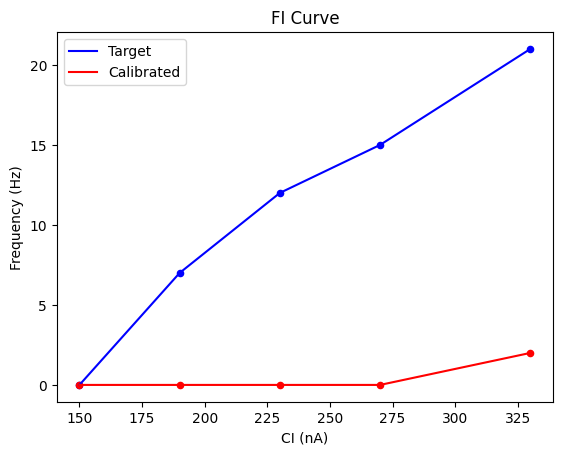

In [ ]:
I = np.array([150, 190, 230, 270, 330])

# Calibrated
simulated_data = np.load("output/L5_after_ACT/combined_out.npy")

f = []
for trace_id in range(len(simulated_data)):
    f.append(len(dp.find_events(simulated_data[trace_id, ::10, 0].flatten(), 5)))
# ---

F = [0, 7, 12, 15, 21]
plt.plot(I, F, label = "Target", c = 'blue')
plt.scatter(I, F, c = 'blue', s = 20)

plt.plot(I, f, label = "Calibrated", c = 'red')
plt.scatter(I, f, c = 'red', s = 20)

plt.xlabel("CI (nA)")
plt.ylabel("Frequency (Hz)")
plt.title("FI Curve")

plt.legend()

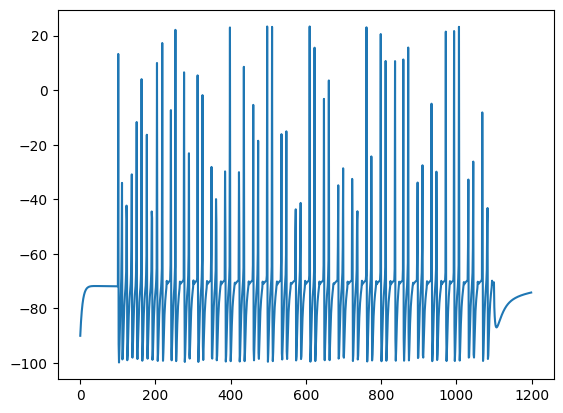

In [416]:
plt.plot(simulated_data[-1, ::10, 0])